In [1]:
%matplotlib inline

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, Input, Lambda
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from PIL import Image
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3879241369864215600
]


Using Helper method triplet sampler taken from https://github.com/akarshzingade/image-similarity-deep-ranking . This will help create a textfile with path to anchor, positive and negative images from the given input directory classes.

In [17]:
from tripletsampler import triplet_sampler,list_pictures
img_width = 256
img_height = 256
batch_size = 8

In [4]:
triplet_sampler("data/train", ".", 3, 3)

This creates a file "triplets.txt" in the same folder as notebook file. Now lets use pandas to read the file

In [5]:
import pandas
import xlrd
import os
import numpy as np

In [6]:
df = pandas.read_csv('triplets.txt',header=None)
df = df.sample(frac=1)
print(df.shape)
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(225, 3)
(225, 3)


0  \
0    data/train\dandelion\138166590_47c6cb9dd0.jpg   
1        data/train\daisy\5794839_200acd910c_n.jpg   
2      data/train\tulip\112651128_7b5d39a346_m.jpg   
3         data/train\rose\685724528_6cd5cbe203.jpg   
4  data/train\sunflower\184682920_97ae41ce60_m.jpg   

                                                 1  \
0  data/train\dandelion\142390525_5d81a3659d_m.jpg   
1      data/train\daisy\506018088_4f7a15a7c5_n.jpg   
2      data/train\tulip\142218310_d06005030a_n.jpg   
3      data/train\rose\2265390547_2409007cef_n.jpg   
4   data/train\sunflower\44079668_34dfee3da1_n.jpg   

                                                2  
0  data/train\sunflower\58636535_bc53ef0a21_m.jpg  
1     data/train\tulip\142218310_d06005030a_n.jpg  
2        data/train\rose\685724528_6cd5cbe203.jpg  
3       data/train\daisy\5547758_eea9edfd54_n.jpg  
4    data/train\tulip\2249756775_02e693beda_n.jpg

In [7]:
dftrain = df.head(200)
dftest = df.tail(25)
dftrain.head()

0  \
0    data/train\dandelion\138166590_47c6cb9dd0.jpg   
1        data/train\daisy\5794839_200acd910c_n.jpg   
2      data/train\tulip\112651128_7b5d39a346_m.jpg   
3         data/train\rose\685724528_6cd5cbe203.jpg   
4  data/train\sunflower\184682920_97ae41ce60_m.jpg   

                                                 1  \
0  data/train\dandelion\142390525_5d81a3659d_m.jpg   
1      data/train\daisy\506018088_4f7a15a7c5_n.jpg   
2      data/train\tulip\142218310_d06005030a_n.jpg   
3      data/train\rose\2265390547_2409007cef_n.jpg   
4   data/train\sunflower\44079668_34dfee3da1_n.jpg   

                                                2  
0  data/train\sunflower\58636535_bc53ef0a21_m.jpg  
1     data/train\tulip\142218310_d06005030a_n.jpg  
2        data/train\rose\685724528_6cd5cbe203.jpg  
3       data/train\daisy\5547758_eea9edfd54_n.jpg  
4    data/train\tulip\2249756775_02e693beda_n.jpg

In [8]:
dftest = dftest.reset_index(drop=True)
dftest.head()

0  \
0  data/train\dandelion\141935731_d26d600f4f_m.jpg   
1      data/train\tulip\116343334_9cb4acdc57_n.jpg   
2   data/train\sunflower\44079668_34dfee3da1_n.jpg   
3  data/train\dandelion\751941983_58e1ae3957_m.jpg   
4         data/train\rose\685724528_6cd5cbe203.jpg   

                                                  1  \
0  data/train\dandelion\1798082733_b8080b1173_m.jpg   
1      data/train\tulip\2249756775_02e693beda_n.jpg   
2    data/train\sunflower\58636535_bc53ef0a21_m.jpg   
3   data/train\dandelion\142390525_5d81a3659d_m.jpg   
4       data/train\rose\2265390547_2409007cef_n.jpg   

                                                 2  
0        data/train\rose\12240303_80d87f77a3_n.jpg  
1  data/train\dandelion\142390525_5d81a3659d_m.jpg  
2       data/train\rose\145862135_ab710de93c_n.jpg  
3  data/train\sunflower\184682920_97ae41ce60_m.jpg  
4  data/train\dandelion\142390525_5d81a3659d_m.jpg

There we go! We have our dataset of over 11K triplets to work with now !! 

Lets load an image from the dataframe, just in case to verify!

data/train\tulip\142218310_d06005030a_n.jpg
data/train\daisy\172882635_4cc7b86731_m.jpg
data/train\daisy\422094774_28acc69a8b_n.jpg


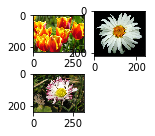

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(dftrain[0][0])
print(dftrain[0][1])
print(dftrain[0][2])
image1 = mpimg.imread(dftrain[0][0]) 
image2 = mpimg.imread(dftrain[0][1])
image3 = mpimg.imread(dftrain[0][2])
fig=plt.figure(figsize=(2, 2))
fig.add_subplot(2, 2,1)
plt.imshow(image1)
fig.add_subplot(2,2,2)
plt.imshow(image2)
fig.add_subplot(2,2,3)
plt.imshow(image3)
plt.show()

Lets load VGGNet model pre trained with imagenet. All we care about are the encodings that are produced from it so that we can train the model further based on loss function. 
TripletLoss helper is also imported from a file 

In [9]:
from triplet_loss import triplet_loss,img_to_encoding, identity_loss
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (256, 256, 3))
x = model.output
x = Flatten()(x)
#x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
#x = Dropout(0.5)(x)
#x = Dense(128, activation="relu")(x)
# L2 normalization
X = Lambda(lambda  x: k.l2_normalize(x,axis=1))(x)
# make till conv4 layer as non trainable 
for i in range(0,14):
    model.layers[i].trainable = False
base_model = Model(input = model.input, output = X)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

C:\Users\sdesikan\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
  


In [11]:
#img_to_encoding(df[0][0], base_model, 256, 256)

In [10]:
from keras import optimizers
#base_model.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
input_1 = Input((img_width,img_height,3))
input_2 = Input((img_width,img_height,3))
input_3 = Input((img_width,img_height,3))

r1 = base_model(input_1)
r2 = base_model(input_2)
r3 = base_model(input_3)
y_pred = [r1,r2,r3]
y_true = (None, None, None)
loss = Lambda(triplet_loss, output_shape=(1,))(y_pred)
print(loss.shape)
model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
model.summary()
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = adam, loss=identity_loss)

()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          18909120    input_2[0][0]                    
                                                                 input_3[0][0]                    
       

In [11]:
row_iterator = 0
def Generate():    
    global row_iterator
    while True:        
        list_a = []
        list_b = []
        list_c = []
        for i in range(batch_size):
            row = dftrain.iloc[[row_iterator]]
            row_iterator += 1
            if row_iterator is 199:
                row_iterator = 0
            anchor_img = Image.open(row[0].values[0].replace("\\","/"))
            anchor_img = anchor_img.resize((img_width,img_height))
            anchor_img_array = np.asarray(anchor_img)
            positive_img = Image.open(row[1].values[0].replace("\\","/"))
            positive_img = positive_img.resize((img_width,img_height))
            positive_img_array = np.asarray(positive_img)
            negative_img = Image.open(row[2].values[0].replace("\\","/"))
            negative_img = negative_img.resize((img_width,img_height))
            negative_img_array = np.asarray(negative_img)
            #x_train = np.array([anchor_img_array, positive_img_array, negative_img_array])
            #anchor  = np.array([anchor_img_array])
            #positive  = np.array([positive_img_array])
            #negative = np.array([negative_img_array])                
            list_a.append(anchor_img_array)
            list_b.append(positive_img_array)
            list_c.append(negative_img_array)            
        A = np.array(list_a, dtype='float32')
        B = np.array(list_b, dtype='float32')
        C = np.array(list_c, dtype='float32')
        label = np.ones(batch_size)
        yield [A,B, C], label

In [12]:
testrow_iterator = 0
def GenerateTest():   
    global testrow_iterator
    while True:        
        list_a = []
        list_b = []
        list_c = []
        for i in range(batch_size):             
            row =  dftest.iloc[[testrow_iterator]]
            testrow_iterator += 1
            if testrow_iterator is 24:
                testrow_iterator = 0
            anchor_img = Image.open(row[0].values[0].replace("\\","/"))
            anchor_img = anchor_img.resize((img_width,img_height))
            anchor_img_array = np.asarray(anchor_img)
            positive_img = Image.open(row[1].values[0].replace("\\","/"))
            positive_img = positive_img.resize((img_width,img_height))
            positive_img_array = np.asarray(positive_img)
            negative_img = Image.open(row[2].values[0].replace("\\","/"))
            negative_img = negative_img.resize((img_width,img_height))
            negative_img_array = np.asarray(negative_img)
            #x_train = np.array([anchor_img_array, positive_img_array, negative_img_array])
            #anchor  = np.array([anchor_img_array])
            #positive  = np.array([positive_img_array])
            #negative = np.array([negative_img_array])                
            list_a.append(anchor_img_array)
            list_b.append(positive_img_array)
            list_c.append(negative_img_array)            
        A = np.array(list_a, dtype='float32')
        B = np.array(list_b, dtype='float32')
        C = np.array(list_c, dtype='float32')
        label = np.ones(batch_size)
        yield [A,B, C], label

In [13]:
train_generator = Generate()
test_generator = GenerateTest()
batch = next(train_generator)
print(model.predict_on_batch(batch[0]))

1.0155644


In [14]:
model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=1, 
                    workers=1,
                    steps_per_epoch=25, 
                    validation_steps=3)

Epoch 1/50
 6/25 [======>.......................] - ETA: 10:29 - loss: 1.3993

KeyboardInterrupt: 

In [21]:
database = {}
directory_path = 'data/train'
classes = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
all_images = []
for class_ in classes:
    all_images += (list_pictures(os.path.join(directory_path,class_)))
for image in all_images:
    database[image] = img_to_encoding(image, base_model, 256, 256)
#print(database)

{'data/train\\daisy\\147068564_32bb4350cc.jpg': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.23721345, 0.        , 0.        , 0.        ,
        0.05055618, 0.        , 0.23836258, 0.        , 0.        ,
        0.        , 0.12368876, 0.11239691, 0.        , 0.        ,
        0.        , 0.        , 0.09045475, 0.08827581, 0.        ,
        0.03778348, 0.        , 0.22066754, 0.        , 0.        ,
        0.04123372, 0.        , 0.        , 0.0198276 , 0.08193394,
        0.        , 0.        , 0.03573186, 0.        , 0.        ,
        0.        , 0.03569365, 0.22766957, 0.26469797, 0.        ,
        0.18746659, 0.        , 0.        , 0.28745726, 0.        ,
        0.01259931, 0.        , 0.        , 0.        , 0.        ,
        0.25263846, 0.16719045, 0.        , 0.        , 0.09727047,
        0.02372589, 0.        , 0.        , 0.        , 0.        ,
        0.1688124 , 0.01638102, 0.04622226, 0.05161212, 0.        ,


In [24]:
image_to_find = "data/train/rose/145862135_ab710de93c_n.jpg"
encoding = img_to_encoding(image_to_find, base_model, 256, 256)
min_dist = 100
min_dist2 = 100
path1 = ""
path2=""
dict_dist = {}
for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding-db_enc)        
        dict_dist[name] = dist
dict(sorted(dict_dist.items(), key=lambda x: x[1]))

{'data/train\\daisy\\147068564_32bb4350cc.jpg': 0.643936,
 'data/train\\daisy\\506018088_4f7a15a7c5_n.jpg': 0.23219074,
 'data/train\\daisy\\5547758_eea9edfd54_n.jpg': 0.323575,
 'data/train\\daisy\\5794839_200acd910c_n.jpg': 0.07960384,
 'data/train\\dandelion\\138166590_47c6cb9dd0.jpg': 0.3247569,
 'data/train\\dandelion\\141935731_d26d600f4f_m.jpg': 0.04556153,
 'data/train\\dandelion\\142390525_5d81a3659d_m.jpg': 0.08781404,
 'data/train\\dandelion\\1798082733_b8080b1173_m.jpg': 0.03911594,
 'data/train\\dandelion\\751941983_58e1ae3957_m.jpg': 0.097762786,
 'data/train\\rose\\118974357_0faa23cce9_n.jpg': 0.021364432,
 'data/train\\rose\\12240303_80d87f77a3_n.jpg': 0.035744622,
 'data/train\\rose\\145862135_ab710de93c_n.jpg': 0.0,
 'data/train\\rose\\2265390547_2409007cef_n.jpg': 0.05462092,
 'data/train\\rose\\685724528_6cd5cbe203.jpg': 0.047119237,
 'data/train\\sunflower\\184682920_97ae41ce60_m.jpg': 0.06364644,
 'data/train\\sunflower\\40411019_526f3fc8d9_m.jpg': 0.07145939,
 'd

from PIL import Image
import numpy as np
inputlist= []
outputlist = []
for index, row in df.iterrows():
    anchor_img = Image.open(row[0])
    anchor_img = anchor_img.resize((img_width,img_height))
    anchor_img_array = np.asarray(anchor_img)
    positive_img = Image.open(row[1])
    positive_img = positive_img.resize((img_width,img_height))
    positive_img_array = np.asarray(positive_img)
    negative_img = Image.open(row[2])
    negative_img = negative_img.resize((img_width,img_height))
    negative_img_array = np.asarray(negative_img)
    #x_train = np.array([anchor_img_array, positive_img_array, negative_img_array])
    anchor  = np.array([anchor_img_array])
    positive  = np.array([positive_img_array])
    negative = np.array([negative_img_array])
    model.fit(x = [anchor, positive, negative], y = np.ones(len(anchor)), epochs=1, callbacks=None, validation_steps=None)
    #print(x_train.shape)
    if index is 100:
        break
    inputlist.append([[anchor, positive, negative]])
    outputlist.append(np.ones(len(anchor)))
#print(inputlist.shape)
datagen = [tuple((y, np.ones(len(y[0])))) for y in inputlist]
#model.fit_generator(data_gen, steps_per_epoch=20, epochs=1, callbacks=None, validation_steps=None)

Now lets begin with training. Iterate over triplets from dataframe and train the model on each run